<a href="https://colab.research.google.com/github/Agresj/robot_vision_cnn/blob/main/robot_vision_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [31]:
# Check for GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Define Data Transformations

In [32]:
# Cell 4: Define Enhanced Transformations for Training and Testing

# Enhanced data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),            # Horizontal flip
    transforms.RandomCrop(32, padding=4),         # Random crop with padding
    transforms.RandomRotation(15),                # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),                        # Convert PIL Image to Tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),  # Normalize
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),  # Random erasing
])

# Only normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),                        # Convert PIL Image to Tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),  # Normalize
])


CIFAR-10 dataset

In [33]:
# Cell 5: Download and Load Training Data with Enhanced Transformations and Validation Split

from torch.utils.data import random_split

# Define the ratio for training and validation splits
train_ratio = 0.9
val_ratio = 0.1

# Calculate the number of samples for each split
total_train = len(trainset)
train_size = int(train_ratio * total_train)
val_size = total_train - train_size

# Split the dataset
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training and validation
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=128,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_subset, batch_size=128,
                                        shuffle=False, num_workers=2)

print(f"Training data loaded with {train_size} samples.")
print(f"Validation data loaded with {val_size} samples.")


Files already downloaded and verified
Training data loaded with enhanced transformations.


In [34]:
# Cell 6: Download and Load Test Data (No Change)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

print("Test data loaded.")


Files already downloaded and verified
Test data loaded.


In [35]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Visualize some training images

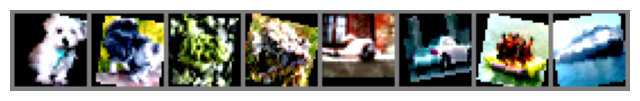

GroundTruth:  dog cat frog frog cat car ship ship


In [36]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(8)))


CNN Architecture

In [37]:
# Cell 9: Define the Enhanced CNN Architecture

class EnhancedNet(nn.Module):
    def __init__(self):
        super(EnhancedNet, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Increased filters from 32 to 64
        self.bn1 = nn.BatchNorm2d(64)
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Increased filters from 64 to 128
        self.bn2 = nn.BatchNorm2d(128)
        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Increased filters from 128 to 256
        self.bn3 = nn.BatchNorm2d(256)
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Increased from 256 to 512
        self.fc2 = nn.Linear(512, 10)
        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Conv Layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        # Conv Layer 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        # Conv Layer 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        # Flatten
        x = x.view(-1, 256 * 4 * 4)
        # Fully connected layer 1
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        # Fully connected layer 2
        x = self.fc2(x)
        return x

# Instantiate the enhanced network
enhanced_net = EnhancedNet()
enhanced_net.to(device)
print(enhanced_net)


EnhancedNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.5, inplace=False)
)


Loss function and Optimizer

In [38]:
# Cell 10: Define Loss Function, Optimizer, and Scheduler

criterion = nn.CrossEntropyLoss()

# Optimizer: Adam with a lower learning rate and weight decay
optimizer = optim.Adam(enhanced_net.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler: Reduce LR by a factor of 0.1 every 15 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

print("Loss function, optimizer, and scheduler defined.")


Loss function, optimizer, and scheduler defined.


Training configuration and Loop

In [39]:
# Cell 11: Set Training Parameters

num_epochs = 50  # Increased number of epochs to allow more training

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


In [40]:
# Cell 12: Train the Enhanced Network with Validation

import copy

start_time = time.time()

best_test_acc = 0.0
best_model_wts = copy.deepcopy(enhanced_net.state_dict())

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    enhanced_net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = enhanced_net(inputs)
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    enhanced_net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = enhanced_net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    epoch_val_loss = val_loss / len(valloader.dataset)
    epoch_val_acc = 100. * correct_val / total_val
    test_losses.append(epoch_val_loss)
    test_accuracies.append(epoch_val_acc)

    # Step the scheduler
    scheduler.step()

    # Checkpointing
    if epoch_val_acc > best_test_acc:
        best_test_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(enhanced_net.state_dict())
        torch.save(best_model_wts, 'best_enhanced_cifar_net.pth')
        print(f'--> Best model saved with Validation Acc: {best_test_acc:.2f}%')

    print(f'Epoch [{epoch +1}/{num_epochs}] '
          f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% '
          f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%')

end_time = time.time()
elapsed_time = (end_time - start_time) / 60
print(f"Training complete in {elapsed_time:.2f} minutes")
print(f"Best Validation Accuracy: {best_test_acc:.2f}%")


--> Best model saved with Test Acc: 39.89%
Epoch [1/50] Train Loss: 2.6217 | Train Acc: 25.31% Test Loss: 1.6510 | Test Acc: 39.89%
--> Best model saved with Test Acc: 49.41%
Epoch [2/50] Train Loss: 1.6962 | Train Acc: 37.91% Test Loss: 1.3980 | Test Acc: 49.41%
--> Best model saved with Test Acc: 54.83%
Epoch [3/50] Train Loss: 1.5369 | Train Acc: 44.11% Test Loss: 1.2521 | Test Acc: 54.83%
--> Best model saved with Test Acc: 61.14%
Epoch [4/50] Train Loss: 1.4002 | Train Acc: 49.79% Test Loss: 1.0732 | Test Acc: 61.14%
--> Best model saved with Test Acc: 62.36%
Epoch [5/50] Train Loss: 1.3080 | Train Acc: 53.32% Test Loss: 1.0583 | Test Acc: 62.36%
--> Best model saved with Test Acc: 62.74%
Epoch [6/50] Train Loss: 1.2213 | Train Acc: 56.41% Test Loss: 1.0713 | Test Acc: 62.74%
--> Best model saved with Test Acc: 65.85%
Epoch [7/50] Train Loss: 1.1717 | Train Acc: 58.51% Test Loss: 0.9681 | Test Acc: 65.85%
Epoch [8/50] Train Loss: 1.1340 | Train Acc: 60.19% Test Loss: 1.0744 | Test

Test Network on Test Data

In [41]:
# Cell 13: Final Evaluation on Test Data

# Load the best model weights
enhanced_net.load_state_dict(torch.load('best_enhanced_cifar_net.pth'))
enhanced_net.eval()

correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = enhanced_net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

final_test_loss = test_loss / len(testloader.dataset)
final_test_acc = 100. * correct / total

print(f'Final Test Loss: {final_test_loss:.4f} | Final Test Accuracy: {final_test_acc:.2f}%')


Final Test Loss: 0.4546 | Final Test Accuracy: 84.46%


Performance Metrics

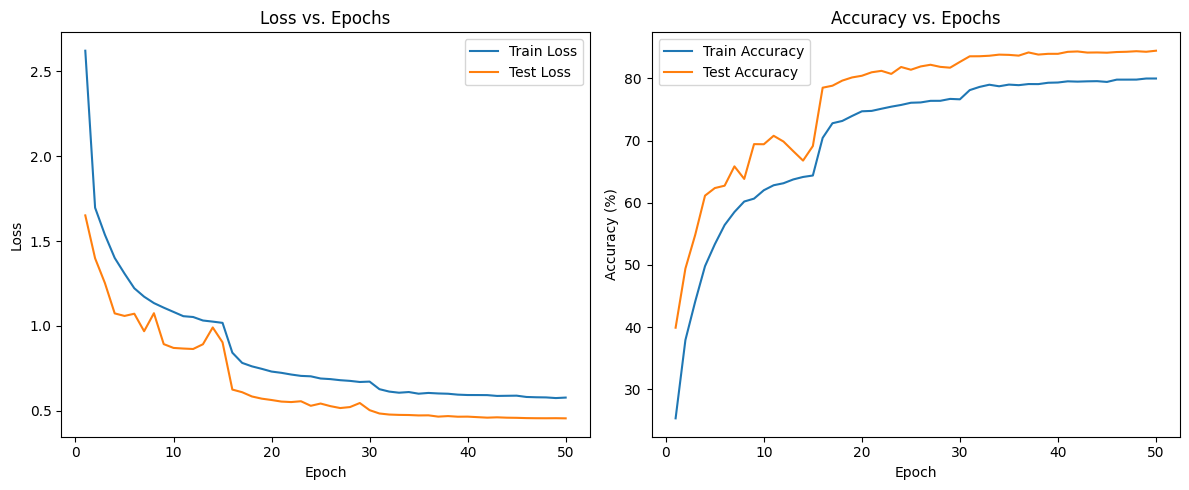

In [42]:
# Cell 14: Plot Enhanced Loss and Accuracy Curves

# Plotting Loss and Accuracy curves
epochs = range(1, num_epochs +1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


Visualize Sample Test Predictions

In [43]:
# Cell 15: Display Some Test Images with Enhanced Predictions

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)  # Updated for Python 3

# Move images and labels to the same device as the model (GPU or CPU)
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = enhanced_net(images)
_, predicted = outputs.max(1)

# Move images and labels back to CPU for plotting
images = images.cpu()
predicted = predicted.cpu()
labels = labels.cpu()

# Show images
imshow(torchvision.utils.make_grid(images[:8]))

# Print ground truth and predictions
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(8)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(8)))


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Saving the model

In [ ]:
# Cell 16: Save the Enhanced Trained Model

# Save the enhanced trained model
PATH = './enhanced_cifar_net.pth'
torch.save(enhanced_net.state_dict(), PATH)
print(f"Enhanced model saved to {PATH}")
